Author: Adrian Swartz<br>
Date: 3/29/2019


# Solutions to Andew Ng's coursera problems
## Example 8b: Collaborative Filtering and Recommender Systems 

This is the last post! 

Andrew Ng's course is designed for the solutions to be worked through in Octave (similar to matlab). However, I am going to do these problems in python (within a jupyter notebook) and demonstrate how various approaches can be implemented in python.

In this exercise, we are tasked with implementing collaborative filtering on a movie review data set.

This notebook is structured as follows:<br>

[Collaborative Filtering](#pt1)<br>
1. [Exploratory Data Analysis](#eda)
2. [Implementing Collaborative Filtering](#cf)

***

For this exercise, we will import several python packages: NumPy (numerical python for matrix manupulations and advanced math), pandas (DataFrames offer a useful platform for importing data and performing exploratory data analysis), matplotlib and seaborn for data visualization.

In [1]:
# Import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
cp=sns.color_palette()

# import a few special packages we'll use for this example
from scipy.io import loadmat
from scipy.optimize import minimize


<a id="pt1"></a>
# Collaborative Filtering

Prompt:<br>
Implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.<br>
This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u$ = 943 users, and $n_m$ = 1682 movies.

The matrix $Y$ (a num movies $\times$ num users matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix $R$ is an binary-valued indicator matrix, where $R^{(i, j)}$ = 1 if user $j$ gave a rating to movie $i$, and $R^{(i, j)}$ = 0 otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R^{(i, j)}$ = 0. This will allow us to recommend the movies with the highest predicted ratings to the user.

The $i$-th row of $X$ corresponds to the feature vector $x^{(i)}$ for the $i$-th movie, and the $j$-th row of Theta corresponds to one parameter vector $\theta^{(j)}$, for the $j$-th user. Both $x^{(i)}$ and $\theta^{(j)}$ are $n$-dimensional vectors. For the purposes of this exercise, you will use $n$ = 100. Correspondingly, $X$ is a $n_m$ $\times$ 100 matrix and Theta is a $n_u$ $\times$ 100 matrix.

***

<a id="eda"></a>
# Exploratory Data Analysis



In [2]:
raw_data = loadmat('ex8/ex8_movies.mat')
raw_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
raw_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

$Y$ is a (number of movies $\times$ number of users) matrix containing ratings from 1 to 5. R is an "indicator" array containing binary values indicating if a user has rated a movie or not. Both should have the same shape.

In [4]:
R = raw_data['R']
Y = raw_data['Y']
R.shape, Y.shape

((1682, 943), (1682, 943))

In [5]:
#1682 movies, 943 users

In [6]:
np.count_nonzero(R == 1), np.count_nonzero(R == 0)

(100000, 1486126)

In [7]:
#100k rated, and 1.5M not rated

We can look at the average rating for a movie by averaging over a row in Y for indexes where a rating is present.



In [8]:
Y[:,0].mean() # average rating for user 0

0.5838287752675386

In [9]:
Y[:,1].mean(), Y[:,100].mean(), Y[:,-1].mean()

(0.1367419738406659, 0.11533888228299644, 0.34066587395957193)

In [10]:
#Should be low because the Y matrix includes movies which were not rated.

In [11]:
Y[np.where(R[:,1]==1),1].mean() #average rating for user 1

3.7096774193548385

(3.5881911071848003, 0.44523349515895827)

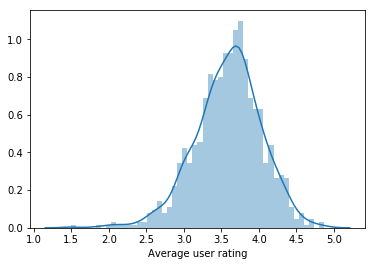

In [12]:
# For movies which were rated, calculate the average rating that each user gave and plot the distribution
users_mean_rated = pd.Series([Y[np.where(R[:,i]==1),i].mean() \
                              for i in range(Y.shape[1])], name="Average user rating")
sns.distplot(users_mean_rated, bins=50)
users_mean_rated.mean(), users_mean_rated.std()

In [13]:
#can also explore the average ratings for each movie by switching from indexing columns to rows

In [14]:
#For only those instances that were rated, average rating for movie 1
movie = 1
Y[movie, np.where(R[movie,:]==1)].mean()

3.2061068702290076

(3.3050661356416806, 0.631248545886858)

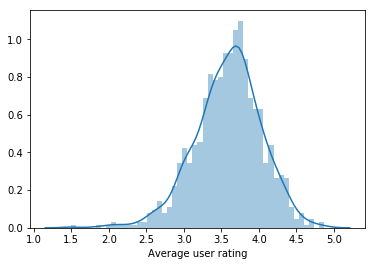

In [15]:
# For movies which were rated, calculate the average rating that each user gave and plot the distribution
movies_mean_rated = pd.Series([Y[i,np.where(R[i,:]==1)].mean() \
                              for i in range(Y.shape[1])], name="Average movie rating")
sns.distplot(users_mean_rated, bins=50)
movies_mean_rated.mean(), movies_mean_rated.std()

In [16]:
# which movie was rated by the most people?

num_users_rated = pd.Series([Y[i,np.where(R[i,:]==1)].shape[1] \
                              for i in range(Y.shape[1])], name="Number user ratings")

np.max(num_users_rated), np.argmax(np.array(num_users_rated))
#The 49th movie had 583 people give it a rating

(583, 49)

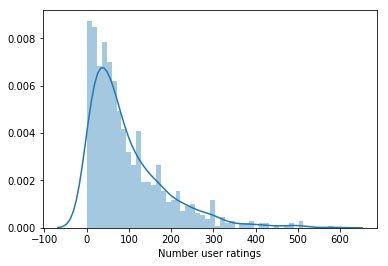

In [17]:
sns.distplot(num_users_rated, bins=50)

Interesting movie rating behavior by people. Either people tend not to rate movies, or they don't watch that many. But overall the population does so in a way characteristic of a Geometric or Exponential distribution.

We can also try to "visualize" the data by rendering the matrix as if it were an image. We can't glean too much from this but it does give us an idea of a relative density of ratings across users and movies.

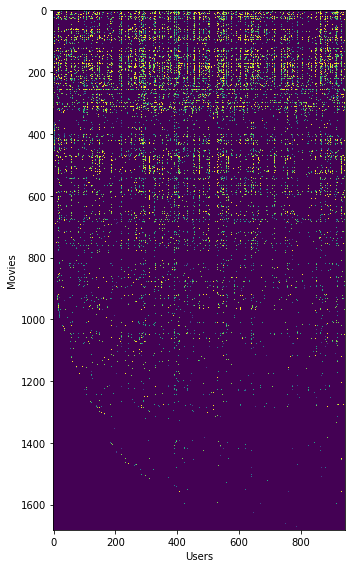

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(Y[:,:], cmap='viridis')
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()

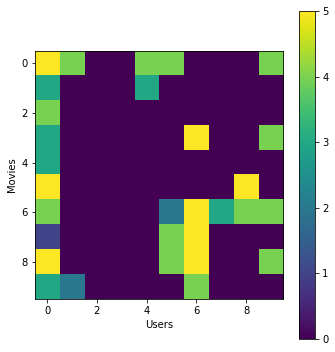

In [19]:
#Let's look at a subset of the first 10x10 part of the reviews
fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(Y[:10,:10], cmap='viridis')
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
plt.colorbar()
fig.tight_layout()
#color scale reflects 

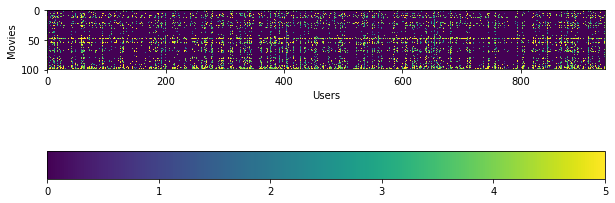

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(Y[:100,:], cmap='viridis')
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
plt.colorbar(orientation='horizontal')

It does look like movie 49 has a large number of entries.
<a id="cf"></a>
# Implementing Collaborative Filtering
Next we're going to implement a cost function for collaborative filtering. Intuitively, the "cost" is the degree to which a set of movie rating predictions deviate from the true predictions. The cost based on two sets of parameter matrices $X$ and $\Theta$. These are "unrolled" into the "params" input so that we can use scipy's optimization functions. 

Just like with the early examples, we need to keep careful track of the matrix shapes.

In [21]:
def cost(params, Y, R, num_features):
    #params goes first because that's what we're going to optimize using scipy
    
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0] #1682
    num_users = Y.shape[1] #943
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    #We're grouping the movies into having 10 categories - Andrew Ng's problem set calls for 100
    
    
    # initialization
    J = 0
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    print('Shapes :: X: {};'.format(X.shape), 'theta: {};'.format(Theta.shape),\
          'X*theta.T: {};'.format((X * Theta.T).shape),'error: {}'.format(error.shape))
   
    return J

For testing, they have provided a set of trained parameters that we can evaluate.

In [22]:
params_data = loadmat('ex8/ex8_movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

((1682, 10), (943, 10))

In [23]:
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))
params.shape

(27,)

In [24]:
cost(params, Y_sub, R_sub, features)

Shapes :: X: (5, 3); theta: (4, 3); X*theta.T: (5, 4); error: (5, 4)


22.224603725685675

Great! This is the same as in `ex8.pdf`.

Our next step is to implement regularized cost and gradient calculations. 

In [25]:
def Reg_Cost_Grad(params, Y, R, num_features, reg_strength):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initialize
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # add the cost regularization
    J = J + ((reg_strength / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((reg_strength / 2) * np.sum(np.power(X, 2)))
    
    # calculate the gradients with regularization
    X_grad = (error * Theta) + (reg_strength * X)
    Theta_grad = (error.T * X) + (reg_strength * Theta)
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

J, grad = Reg_Cost_Grad(params, Y_sub, R_sub, features, 1.5)
J, grad

(31.34405624427422,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

This agrees with the exercise code, so it looks like the regularization is working. 

Before we start training, we are first asked to create our own movie ratings so we can use the model to generate personalized recommendations. A file is provided for us that links the movie index to its title. 

We need to load the file (into a dictionary) and assign the sample ratings provided in the exercise.

In [26]:

# in python 3, the unicode will throw an error when it reads this file
# crazy annoying bug 
f = open('ex8/movie_ids.txt','r',encoding='latin-1')  

movie_idx = {}

for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])
    
f.close() # always close the file!

movie_idx[0]

'Toy Story (1995)'

In [27]:
my_ratings = np.zeros((1682, 1))

#Let's say I want to rate 100 movies (randomly) on a scale of 1 to 5 (randomly). 
indices = np.random.randint(0, high=1682, size=100)

for i in indices:
    my_ratings[i]=np.random.randint(1,high=5)
    print('Rated {} with {} stars.'.format(movie_idx[i], str(int(my_ratings[i]))))

# this isn't perfect. I'm being lazy here by rating on a random distribution. 

Rated Clockwork Orange, A (1971) with 4 stars.
Rated Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996) with 1 stars.
Rated Replacement Killers, The (1998) with 3 stars.
Rated Of Human Bondage (1934) with 3 stars.
Rated Chairman of the Board (1998) with 2 stars.
Rated Maltese Falcon, The (1941) with 1 stars.
Rated Palmetto (1998) with 3 stars.
Rated Some Kind of Wonderful (1987) with 4 stars.
Rated Man Without a Face, The (1993) with 1 stars.
Rated Red Rock West (1992) with 1 stars.
Rated Bound (1996) with 1 stars.
Rated Unzipped (1995) with 4 stars.
Rated Gone Fishin' (1997) with 3 stars.
Rated Third Man, The (1949) with 2 stars.
Rated Stag (1997) with 2 stars.
Rated Private Benjamin (1980) with 4 stars.
Rated Shadow of Angels (Schatten der Engel) (1976) with 1 stars.
Rated Amityville Horror, The (1979) with 3 stars.
Rated Kazaam (1996) with 4 stars.
Rated Kicking and Screaming (1995) with 4 stars.
Rated Dangerous Ground (1997) with 3 stars.
Rated Bananas 

In [29]:
#add custom data
R = raw_data['R']
Y = raw_data['Y']

Y = np.append(Y, my_ratings, axis=1)
R = np.append(R, my_ratings != 0, axis=1)

We're now ready to train the collaborative filtering model. We're going to normalize the ratings and then run the optimization routine using our cost function, parameter vector, and data matrices at inputs.

In [30]:

movies = Y.shape[0]
users = Y.shape[1]
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

fmin = minimize(fun=Reg_Cost_Grad, x0=params, args=(Ynorm, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 1000})
fmin

     fun: 39024.85756790169
     jac: array([2.28849595e-06, 8.64045566e-07, 5.36109711e-07, ...,
       2.19986784e-07, 1.18598025e-06, 2.91169629e-07])
 message: 'Optimization terminated successfully.'
    nfev: 735
     nit: 493
    njev: 735
  status: 0
 success: True
       x: array([-0.13540114, -0.16239788,  0.82414623, ...,  0.04456677,
       -0.6783258 , -0.52168155])

In [31]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape
#re-roll

((1682, 10), (944, 10))

Our trained parameters are now in $X$ and $\Theta$. We can use these to create some recommendations for the user we added earlier.

In [32]:
predictions = X * Theta.T 
my_preds = predictions[:, -1] + Ymean
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:20]

matrix([[5.        ],
        [5.        ],
        [5.        ],
        [5.        ],
        [5.        ],
        [5.        ],
        [5.        ],
        [5.        ],
        [5.        ],
        [5.        ],
        [4.50166044],
        [4.4539865 ],
        [4.4426599 ],
        [4.4410207 ],
        [4.37002473],
        [4.32597216],
        [4.25663387],
        [4.25199802],
        [4.24120317],
        [4.24116527]])

In [35]:
idx = np.argsort(my_preds, axis=0)[::-1]
print("Top 10 movie predictions:")
for i in range(50):
    j = int(idx[i])
    print('Predicted Rating: {:.4} for "{}".'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted Rating: 5.00 for "They Made Me a Criminal (1939)".
Predicted Rating: 5.00 for "Marlene Dietrich: Shadow and Light (1996) ".
Predicted Rating: 5.00 for "Saint of Fort Washington, The (1993)".
Predicted Rating: 4.99 for "Great Day in Harlem, A (1994)".
Predicted Rating: 4.99 for "Entertaining Angels: The Dorothy Day Story (1996)".
Predicted Rating: 4.99 for "Someone Else's America (1995)".
Predicted Rating: 4.99 for "Santa with Muscles (1996)".
Predicted Rating: 4.99 for "Aiqing wansui (1994)".
Predicted Rating: 4.99 for "Star Kid (1997)".
Predicted Rating: 4.99 for "Prefontaine (1997)".
Predicted Rating: 4.50 for "Everest (1998)".
Predicted Rating: 4.45 for "Some Mother's Son (1996)".
Predicted Rating: 4.44 for "Anna (1996)".
Predicted Rating: 4.44 for "Pather Panchali (1955)".
Predicted Rating: 4.37 for "Bitter Sugar (Azucar Amargo) (1996)".
Predicted Rating: 4.32 for "Kaspar Hauser (1993)".
Predicted Rating: 4.25 for "Sound of Music, The (1965)".
Pr

Cool! We've built a movie recommender system by taking advantage of collaborative filtering. There's certainly many things that could be improved, and validation is of course trickly, but it's a great introduction to collaborative filtering!

All done!